In [56]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np

1. Load in the csv file. 

In [57]:
df = pd.read_csv('aqi_ny.csv')

2. Drop the extra index.

In [58]:
df = df.drop('Unnamed: 0', axis=1)

In [59]:
df

,date,co,no,no2,o3,so2,pm2_5,pm10,nh3,aqi,latitude,longitude,city
0,2020-12-01 05:00:00,373.84,1.50,43.87,8.49,6.86,9.31,11.75,1.30,2,40.7127,-74.006,"New York, NY"
1,2020-12-01 06:00:00,343.80,1.16,37.70,9.39,7.09,8.43,10.47,1.09,1,40.7127,-74.006,"New York, NY"
2,2020-12-01 07:00:00,337.12,1.79,35.99,6.35,7.21,8.55,10.80,1.08,1,40.7127,-74.006,"New York, NY"
3,2020-12-01 08:00:00,337.12,3.38,34.96,3.09,7.63,8.92,11.57,1.08,1,40.7127,-74.006,"New York, NY"
4,2020-12-01 09:00:00,340.46,5.87,33.59,1.16,8.23,9.62,12.64,1.09,1,40.7127,-74.006,"New York, NY"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18056,2022-12-31 13:00:00,821.11,62.58,61.69,0.00,5.48,36.08,44.15,3.39,3,40.7127,-74.006,"New York, NY"
18057,2022-12-31 14:00:00,1028.06,92.09,69.23,0.12,6.56,45.75,56.04,3.96,3,40.7127,-74.006,"New York, NY"
18058,2022-12-31 15:00:00,1134.87,104.61,69.23,0.46,8.11,50.21,61.68,4.12,4,40.7127,-74.006,"New York, NY"
18059,2022-12-31 16:00:00,1121.52,101.92,64.43,0.44,9.42,48.14,59.03,4.18,3,40.7127,-74.006,"New York, NY"


3. Make the date column the index, and get rid of the extra date column so there's not a duplicate.

In [60]:
df.index = pd.to_datetime(df['date'])

In [61]:
df = df.drop('date', axis=1)

In [62]:
pm25 = df['pm2_5']

4. Visualize your data. 

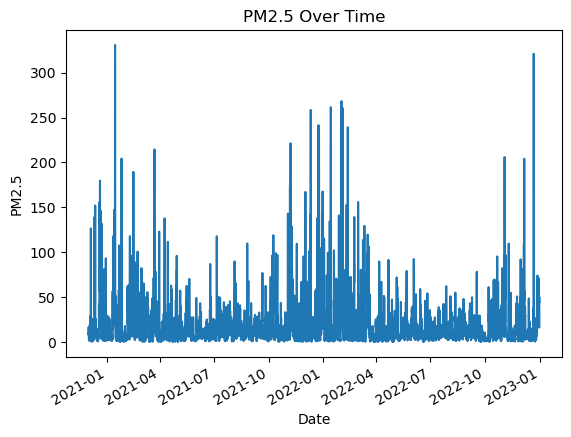

In [63]:
pm25.plot(title= 'PM2.5 Over Time', ylabel = 'PM2.5', xlabel = 'Date');

6. What makes LSTM much better at predicting time series data is that it takes into account a certain amount of values to predict the next one. In this case, the window size is 8, so it is looking at the first 8 values to predict value number 9, next it uses values 2 to 9 to predict 10, and so on. This function gets the data into this format, where X are the predictor values and y is what is being predicted. 

In [64]:
def df_to_X_y(df, window_size=8):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [[a] for a in df_as_np[i:i+8]]
        X.append(row)
        label = df_as_np[i+5]
        y.append(label)
    return np.array(X), np.array(y)

7. This shows us the shape of X and y, for both there are 18056 arrays, but X has 8 lists in each array since our window size is 8, and y only has one since we are predicting one value at a time. 

In [65]:
window_size = 8
X, y = df_to_X_y(pm25, window_size)
X.shape, y.shape

((18053, 8, 1), (18053,))

8. Split the data into a training set, a validation set, and a testing set. 

In [66]:
X_train, y_train = X[:12000], y[:12000]
X_val, y_val = X[12000:15000], y[12000:15000]
X_test, y_test = X[15000:], y[15000:]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((12000, 8, 1), (12000,), (3000, 8, 1), (3000,), (3053, 8, 1), (3053,))

In [67]:
from keras.models import Sequential
from keras.layers import *
from keras.callbacks import ModelCheckpoint
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam 

9. Create the model. For the first layer you have to specify the shape of your model, since the window size is 8 and we only have one predictor the layer is 8 by 1. Next comes 1 LSTM layer, since LSTM is a neural network you have to specify the number of neurons, 32, 64, 128, and 256 are all common. Two dense layers follow the LSTM layer, the last dense layer is responsible for the regression task, and in this case we specify 1 because we want the output to be 1 predicted value.

In [68]:
model1 = Sequential()
model1.add(InputLayer((8,1)))
model1.add(LSTM(64))
model1.add(Dense(8,'relu'))
model1.add(Dense(1,'linear'))

model1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 64)                16896     
                                                                 
 dense_6 (Dense)             (None, 8)                 520       
                                                                 
 dense_7 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


10. Create a checkpoint that saves the best performing model. Just like our XGBoost model, we are using a low learning rate so it will be slower. 

In [69]:
cp = ModelCheckpoint('model1/',save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer = Adam(learning_rate=0.0001), metrics=RootMeanSquaredError())

11. Fit the model. The number you choose for your epochs specifies how many times you will run through the data, so the larger the number the longer it will take to run. 

In [70]:
model1.fit(X_train,y_train, validation_data=(X_val,y_val), epochs=25, callbacks=[cp])

Epoch 1/25
372/375 [============================>.] - ETA: 0s - loss: 993.7001 - root_mean_squared_error: 31.5230

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 17s 36ms/step - loss: 993.5306 - root_mean_squared_error: 31.5203 - val_loss: 142.4574 - val_root_mean_squared_error: 11.9355
Epoch 2/25
373/375 [============================>.] - ETA: 0s - loss: 829.1007 - root_mean_squared_error: 28.7941

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 11s 30ms/step - loss: 830.7561 - root_mean_squared_error: 28.8228 - val_loss: 75.1489 - val_root_mean_squared_error: 8.6688
Epoch 3/25
374/375 [============================>.] - ETA: 0s - loss: 676.0946 - root_mean_squared_error: 26.0018

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 12s 33ms/step - loss: 675.5547 - root_mean_squared_error: 25.9914 - val_loss: 42.6986 - val_root_mean_squared_error: 6.5344
Epoch 4/25
370/375 [============================>.] - ETA: 0s - loss: 568.0804 - root_mean_squared_error: 23.8344

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 11s 29ms/step - loss: 564.7515 - root_mean_squared_error: 23.7645 - val_loss: 26.7786 - val_root_mean_squared_error: 5.1748
Epoch 5/25
374/375 [============================>.] - ETA: 0s - loss: 484.6100 - root_mean_squared_error: 22.0139

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 12s 31ms/step - loss: 484.9815 - root_mean_squared_error: 22.0223 - val_loss: 18.2044 - val_root_mean_squared_error: 4.2667
Epoch 6/25
371/375 [============================>.] - ETA: 0s - loss: 420.9887 - root_mean_squared_error: 20.5180

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 12s 31ms/step - loss: 421.2431 - root_mean_squared_error: 20.5242 - val_loss: 12.9816 - val_root_mean_squared_error: 3.6030
Epoch 7/25
375/375 [==============================] - ETA: 0s - loss: 367.3641 - root_mean_squared_error: 19.1667

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 10s 28ms/step - loss: 367.3641 - root_mean_squared_error: 19.1667 - val_loss: 9.7863 - val_root_mean_squared_error: 3.1283
Epoch 8/25
372/375 [============================>.] - ETA: 0s - loss: 320.2713 - root_mean_squared_error: 17.8961

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 12s 31ms/step - loss: 321.1198 - root_mean_squared_error: 17.9198 - val_loss: 7.2986 - val_root_mean_squared_error: 2.7016
Epoch 9/25
375/375 [==============================] - ETA: 0s - loss: 281.4089 - root_mean_squared_error: 16.7752

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 12s 31ms/step - loss: 281.4089 - root_mean_squared_error: 16.7752 - val_loss: 5.4477 - val_root_mean_squared_error: 2.3340
Epoch 10/25
371/375 [============================>.] - ETA: 0s - loss: 247.9922 - root_mean_squared_error: 15.7478

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 10s 27ms/step - loss: 247.5501 - root_mean_squared_error: 15.7337 - val_loss: 4.2661 - val_root_mean_squared_error: 2.0655
Epoch 11/25
374/375 [============================>.] - ETA: 0s - loss: 218.6090 - root_mean_squared_error: 14.7854

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 11s 28ms/step - loss: 218.1438 - root_mean_squared_error: 14.7697 - val_loss: 3.0596 - val_root_mean_squared_error: 1.7492
Epoch 12/25
373/375 [============================>.] - ETA: 0s - loss: 193.5870 - root_mean_squared_error: 13.9136

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 11s 28ms/step - loss: 192.5783 - root_mean_squared_error: 13.8773 - val_loss: 2.4745 - val_root_mean_squared_error: 1.5731
Epoch 13/25
374/375 [============================>.] - ETA: 0s - loss: 170.7498 - root_mean_squared_error: 13.0671

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 11s 30ms/step - loss: 170.4258 - root_mean_squared_error: 13.0547 - val_loss: 2.0557 - val_root_mean_squared_error: 1.4338
Epoch 14/25
373/375 [============================>.] - ETA: 0s - loss: 151.6713 - root_mean_squared_error: 12.3155

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 10s 28ms/step - loss: 150.9049 - root_mean_squared_error: 12.2843 - val_loss: 1.7523 - val_root_mean_squared_error: 1.3237
Epoch 15/25
375/375 [==============================] - ETA: 0s - loss: 133.6581 - root_mean_squared_error: 11.5611

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 13s 34ms/step - loss: 133.6581 - root_mean_squared_error: 11.5611 - val_loss: 1.4926 - val_root_mean_squared_error: 1.2217
Epoch 16/25
370/375 [============================>.] - ETA: 0s - loss: 119.1624 - root_mean_squared_error: 10.9162

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 11s 29ms/step - loss: 118.6376 - root_mean_squared_error: 10.8921 - val_loss: 1.3288 - val_root_mean_squared_error: 1.1527
Epoch 17/25
371/375 [============================>.] - ETA: 0s - loss: 105.1783 - root_mean_squared_error: 10.2556

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 12s 31ms/step - loss: 105.5423 - root_mean_squared_error: 10.2734 - val_loss: 1.1952 - val_root_mean_squared_error: 1.0933
Epoch 18/25
373/375 [============================>.] - ETA: 0s - loss: 94.4067 - root_mean_squared_error: 9.7163

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 12s 32ms/step - loss: 94.0527 - root_mean_squared_error: 9.6981 - val_loss: 1.0714 - val_root_mean_squared_error: 1.0351
Epoch 19/25
375/375 [==============================] - ETA: 0s - loss: 84.1603 - root_mean_squared_error: 9.1739

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 10s 27ms/step - loss: 84.1603 - root_mean_squared_error: 9.1739 - val_loss: 0.9807 - val_root_mean_squared_error: 0.9903
Epoch 20/25
373/375 [============================>.] - ETA: 0s - loss: 75.8632 - root_mean_squared_error: 8.7099

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 12s 31ms/step - loss: 75.4994 - root_mean_squared_error: 8.6890 - val_loss: 0.9218 - val_root_mean_squared_error: 0.9601
Epoch 21/25
372/375 [============================>.] - ETA: 0s - loss: 68.3178 - root_mean_squared_error: 8.2655

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 10s 27ms/step - loss: 67.8017 - root_mean_squared_error: 8.2342 - val_loss: 0.8253 - val_root_mean_squared_error: 0.9085
Epoch 22/25
375/375 [==============================] - 5s 13ms/step - loss: 60.9369 - root_mean_squared_error: 7.8062 - val_loss: 0.8526 - val_root_mean_squared_error: 0.9233
Epoch 23/25
375/375 [==============================] - 5s 13ms/step - loss: 54.9483 - root_mean_squared_error: 7.4127 - val_loss: 0.8323 - val_root_mean_squared_error: 0.9123
Epoch 24/25
373/375 [============================>.] - ETA: 0s - loss: 49.8590 - root_mean_squared_error: 7.0611

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 12s 33ms/step - loss: 49.6727 - root_mean_squared_error: 7.0479 - val_loss: 0.7276 - val_root_mean_squared_error: 0.8530
Epoch 25/25
374/375 [============================>.] - ETA: 0s - loss: 45.1426 - root_mean_squared_error: 6.7188

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 10s 28ms/step - loss: 45.0238 - root_mean_squared_error: 6.7100 - val_loss: 0.7141 - val_root_mean_squared_error: 0.8450


In [71]:
from keras.models import load_model

12. Load the model so we can work with the best one. 

In [72]:
model1 = load_model('model1/')

13. Calculate the predicted values for the training set and add them to a dataframe with the actuals.

In [73]:
train_predictions = model1.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train})
train_results

375/375 [==============================] - 2s 5ms/step


,Train Predictions,Actuals
0,10.353524,10.60
1,12.202385,11.92
2,14.896389,15.04
3,16.422392,16.85
4,16.002851,15.64
...,...,...
11995,2.340687,2.45
11996,2.651696,2.90
11997,3.267350,3.48
11998,4.309959,4.54


14. Visualize the data to compare predicted values to the actual values for the training set. As you can see, the model did a very good job of predicting values since the lines are pretty much on top of each other.

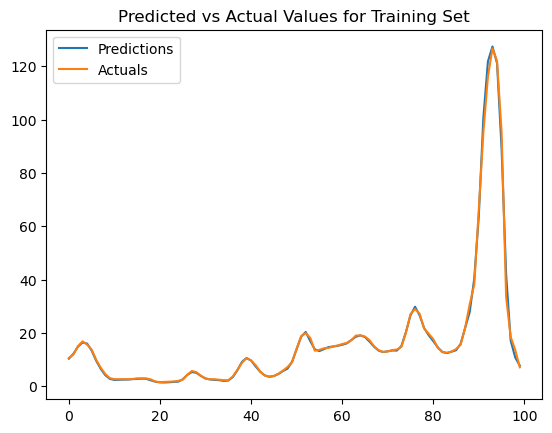

In [74]:
import matplotlib.pyplot as plt
plt.plot(train_results['Train Predictions'][:100])
plt.plot(train_results['Actuals'][:100])
plt.title('Predicted vs Actual Values for Training Set')
plt.legend(['Predictions','Actuals']);

15. Calculate the predicted values for the validation set and add them to a dataframe with the actuals.

In [75]:
val_predictions = model1.predict(X_val).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val})
val_results

94/94 [==============================] - 2s 7ms/step


,Val Predictions,Actuals
0,8.392590,7.60
1,11.923605,11.78
2,10.300395,12.08
3,7.234483,5.95
4,7.085346,6.47
...,...,...
2995,20.295280,20.61
2996,19.356161,19.86
2997,18.134218,18.63
2998,17.664373,17.85


16. Visualize the data to compare predicted values to the actual values for the validation set. It looks like the model did a good job, but the predicted values are a little lower when it comes to the big spikes. 

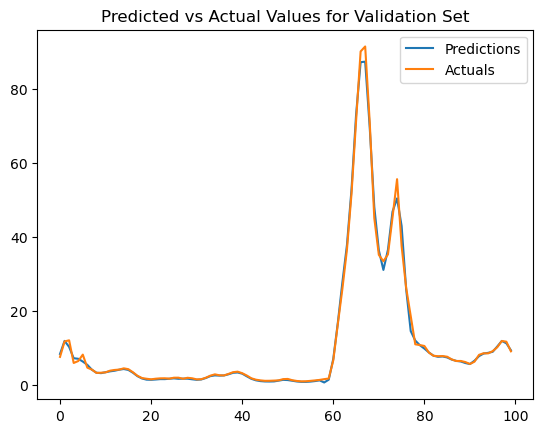

In [76]:
plt.plot(val_results['Val Predictions'][:100])
plt.plot(val_results['Actuals'][:100])
plt.title('Predicted vs Actual Values for Validation Set')
plt.legend(['Predictions','Actuals']);

17. Calculate the predicted values for the test set and add them to a dataframe along with the actuals.

In [77]:
test_predictions = model1.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test})
test_results

96/96 [==============================] - 1s 7ms/step


,Test Predictions,Actuals
0,17.937584,18.85
1,17.294014,16.84
2,17.434206,17.90
3,19.384207,19.42
4,23.092365,22.37
...,...,...
3048,16.173412,16.50
3049,18.179623,17.82
3050,24.886572,24.86
3051,36.014240,36.08


18. Visualize the data to compare predicted values to the actual values for the test set. This time, it looks like the model overshot the actual values since the predicted line rises above the line for the actuals on the first two spikes. 

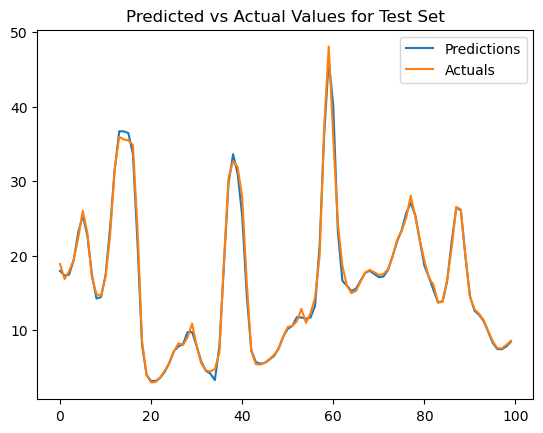

In [78]:
plt.plot(test_results['Test Predictions'][:100])
plt.plot(test_results['Actuals'][:100])
plt.title('Predicted vs Actual Values for Test Set')
plt.legend(['Predictions','Actuals']);

In [79]:
from sklearn.metrics import r2_score

19. Calculate the coefficient of determination for the training set, validation set, and testing set. As you can see, the model performed very well when you consider that we did not have to add any extra features like we had to for the XGBoost model. When we tested the XGBoost model's training score with no added features it was .12, so this model performs much better at its most basic level. 

In [80]:
train_r2 = r2_score(train_results['Actuals'],train_results['Train Predictions'])
train_r2

0.9409562592403462

In [81]:
val_r2 = r2_score(val_results['Actuals'],val_results['Val Predictions'])
val_r2

0.9932296933631557

In [82]:
test_r2 = r2_score(test_results['Actuals'],test_results['Test Predictions'])
test_r2

0.8882142638376501

20. Create a second model. This time we are adding features to help it get a better sense of how the data progresses with time so that its performance is hopefully improved. As we saw before, this is not as necessary as when you use XGBoost to predict time series data, but we want to try and refine our model. 

In [83]:
pm25_df = pd.DataFrame({'pm2_5':pm25})
pm25_df['seconds'] = pm25_df.index.map(pd.Timestamp.timestamp)
pm25_df

,pm2_5,seconds
date,,
2020-12-01 05:00:00,9.31,1.606799e+09
2020-12-01 06:00:00,8.43,1.606802e+09
2020-12-01 07:00:00,8.55,1.606806e+09
2020-12-01 08:00:00,8.92,1.606810e+09
2020-12-01 09:00:00,9.62,1.606813e+09
...,...,...
2022-12-31 13:00:00,36.08,1.672492e+09
2022-12-31 14:00:00,45.75,1.672495e+09
2022-12-31 15:00:00,50.21,1.672499e+09


21. Use the seconds column to create columns for Day sin, Day cos, Year sin, and Year cos. These features are similar to the lag features that we used for our XGBoost model in that they are there to give a sense of relative time, but these are referred to as cyclical features. 

In [84]:
day = 60*60*24
year = 365.2425*day 

pm25_df['Day sin'] = np.sin(pm25_df['seconds'] * (2*np.pi / day))
pm25_df['Day cos'] = np.cos(pm25_df['seconds'] * (2*np.pi / day))
pm25_df['Year sin'] = np.sin(pm25_df['seconds'] * (2*np.pi / year))
pm25_df['Year cos'] = np.cos(pm25_df['seconds'] * (2*np.pi / year))

In [85]:
pm25_df

,pm2_5,seconds,Day sin,Day cos,Year sin,Year cos
date,,,,,,
2020-12-01 05:00:00,9.31,1.606799e+09,0.965926,2.588190e-01,-0.495857,0.868404
2020-12-01 06:00:00,8.43,1.606802e+09,1.000000,1.086286e-11,-0.495234,0.868759
2020-12-01 07:00:00,8.55,1.606806e+09,0.965926,-2.588190e-01,-0.494612,0.869114
2020-12-01 08:00:00,8.92,1.606810e+09,0.866025,-5.000000e-01,-0.493988,0.869468
2020-12-01 09:00:00,9.62,1.606813e+09,0.707107,-7.071068e-01,-0.493365,0.869822
...,...,...,...,...,...,...
2022-12-31 13:00:00,36.08,1.672492e+09,-0.258819,-9.659258e-01,-0.005347,0.999986
2022-12-31 14:00:00,45.75,1.672495e+09,-0.500000,-8.660254e-01,-0.004630,0.999989
2022-12-31 15:00:00,50.21,1.672499e+09,-0.707107,-7.071068e-01,-0.003914,0.999992


22. Drop the seconds column since it is no longer necessary now that we have created the extra columns. 

In [86]:
aqi_df = pm25_df.drop('seconds', axis=1)

In [87]:
aqi_df

,pm2_5,Day sin,Day cos,Year sin,Year cos
date,,,,,
2020-12-01 05:00:00,9.31,0.965926,2.588190e-01,-0.495857,0.868404
2020-12-01 06:00:00,8.43,1.000000,1.086286e-11,-0.495234,0.868759
2020-12-01 07:00:00,8.55,0.965926,-2.588190e-01,-0.494612,0.869114
2020-12-01 08:00:00,8.92,0.866025,-5.000000e-01,-0.493988,0.869468
2020-12-01 09:00:00,9.62,0.707107,-7.071068e-01,-0.493365,0.869822
...,...,...,...,...,...
2022-12-31 13:00:00,36.08,-0.258819,-9.659258e-01,-0.005347,0.999986
2022-12-31 14:00:00,45.75,-0.500000,-8.660254e-01,-0.004630,0.999989
2022-12-31 15:00:00,50.21,-0.707107,-7.071068e-01,-0.003914,0.999992


23. This is the same function as before, but it makes it so that there are 8 lists in each array since the window size is 8, and each array has 5 values since we have 5 features now (PM2.5, day sin, day cos, year sin, and year cos).

In [88]:
def df_to_X_y2(df, window_size=8):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [r for r in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size][0]
        y.append(label)
    return np.array(X), np.array(y)

In [89]:
X2, y2 = df_to_X_y2(aqi_df)
X2.shape, y2.shape 

((18053, 8, 5), (18053,))

24. Separate the data into a training set, a validation set, and a testing set. 

In [90]:
X2_train, y2_train = X2[:12000], y2[:12000]
X2_val, y2_val = X2[12000:15000], y2[12000:15000]
X2_test, y2_test = X2[15000:], y2[15000:]
X2_train.shape, y2_train.shape, X2_val.shape, y2_val.shape, X2_test.shape, y2_test.shape

((12000, 8, 5), (12000,), (3000, 8, 5), (3000,), (3053, 8, 5), (3053,))

25. Standardize the data so that all the values are on a similar scale. 

In [91]:
pm25_training_mean = np.mean(X2_train[:, :, 0])
pm25_training_std = np.std(X2_train[:, :, 0])

def preprocess(X):
    X[:, :, 0] = (X[:, :, 0] - pm25_training_mean) / pm25_training_std
    return X

In [92]:
preprocess(X2_train)
preprocess(X2_val)
preprocess(X2_test)

array([[[ 7.63055244e-02,  9.65925826e-01,  2.58819045e-01,
         -7.79677220e-01, -6.26181629e-01],
        [ 4.83556901e-02,  1.00000000e+00,  9.43975630e-12,
         -7.80125855e-01, -6.25622610e-01],
        [ 2.51796176e-03,  9.65925826e-01, -2.58819045e-01,
         -7.80574090e-01, -6.25063269e-01],
        ...,
        [ 1.07165798e-02,  5.00000000e-01, -8.66025404e-01,
         -7.81916387e-01, -6.23383320e-01],
        [-6.41889762e-02,  2.58819045e-01, -9.65925826e-01,
         -7.82363017e-01, -6.22822696e-01],
        [-2.46865437e-02,  1.20031004e-11, -1.00000000e+00,
         -7.82809244e-01, -6.22261752e-01]],

       [[ 4.83556901e-02,  1.00000000e+00,  9.43975630e-12,
         -7.80125855e-01, -6.25622610e-01],
        [ 2.51796176e-03,  9.65925826e-01, -2.58819045e-01,
         -7.80574090e-01, -6.25063269e-01],
        [-2.65498660e-02,  8.66025404e-01, -5.00000000e-01,
         -7.81021924e-01, -6.24503606e-01],
        ...,
        [-6.41889762e-02,  2.5881904

26. Create the model, everything stays the same as the first attempt but the InputLayer since the dimensions have now changed because we added those extra time features. 

In [93]:
model2 = Sequential()
model2.add(InputLayer((8, 5)))
model2.add(LSTM(64))
model2.add(Dense(8,'relu'))
model2.add(Dense(1,'linear'))

model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 64)                17920     
                                                                 
 dense_8 (Dense)             (None, 8)                 520       
                                                                 
 dense_9 (Dense)             (None, 1)                 9         
                                                                 
Total params: 18,449
Trainable params: 18,449
Non-trainable params: 0
_________________________________________________________________


27. Create the checkpoint to save the best model.

In [94]:
cp2 = ModelCheckpoint('model2/',save_best_only=True)
model2.compile(loss=MeanSquaredError(), optimizer = Adam(learning_rate=0.0001), metrics=RootMeanSquaredError())

28. Fit the model.

In [95]:
model2.fit(X2_train,y2_train, validation_data=(X2_val,y2_val), epochs=25, callbacks=[cp2])

Epoch 1/25
373/375 [============================>.] - ETA: 0s - loss: 985.4294 - root_mean_squared_error: 31.3916

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 15s 31ms/step - loss: 981.9498 - root_mean_squared_error: 31.3361 - val_loss: 206.6634 - val_root_mean_squared_error: 14.3758
Epoch 2/25
370/375 [============================>.] - ETA: 0s - loss: 659.4167 - root_mean_squared_error: 25.6791

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 11s 30ms/step - loss: 663.7059 - root_mean_squared_error: 25.7625 - val_loss: 80.8315 - val_root_mean_squared_error: 8.9906
Epoch 3/25
372/375 [============================>.] - ETA: 0s - loss: 570.3365 - root_mean_squared_error: 23.8817

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 12s 32ms/step - loss: 570.7507 - root_mean_squared_error: 23.8904 - val_loss: 77.5388 - val_root_mean_squared_error: 8.8056
Epoch 4/25
372/375 [============================>.] - ETA: 0s - loss: 510.5986 - root_mean_squared_error: 22.5964

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 11s 29ms/step - loss: 513.4573 - root_mean_squared_error: 22.6596 - val_loss: 68.7425 - val_root_mean_squared_error: 8.2911
Epoch 5/25
372/375 [============================>.] - ETA: 0s - loss: 460.3982 - root_mean_squared_error: 21.4569

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 13s 34ms/step - loss: 457.5724 - root_mean_squared_error: 21.3909 - val_loss: 55.2728 - val_root_mean_squared_error: 7.4346
Epoch 6/25
373/375 [============================>.] - ETA: 0s - loss: 398.1480 - root_mean_squared_error: 19.9536

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 15s 41ms/step - loss: 401.9180 - root_mean_squared_error: 20.0479 - val_loss: 47.1988 - val_root_mean_squared_error: 6.8701
Epoch 7/25
374/375 [============================>.] - ETA: 0s - loss: 342.3224 - root_mean_squared_error: 18.5020

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 11s 30ms/step - loss: 343.3746 - root_mean_squared_error: 18.5304 - val_loss: 44.0600 - val_root_mean_squared_error: 6.6378
Epoch 8/25
371/375 [============================>.] - ETA: 0s - loss: 297.7581 - root_mean_squared_error: 17.2557

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 11s 28ms/step - loss: 298.4804 - root_mean_squared_error: 17.2766 - val_loss: 40.8866 - val_root_mean_squared_error: 6.3943
Epoch 9/25
375/375 [==============================] - ETA: 0s - loss: 261.6330 - root_mean_squared_error: 16.1751

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 13s 35ms/step - loss: 261.6330 - root_mean_squared_error: 16.1751 - val_loss: 36.1683 - val_root_mean_squared_error: 6.0140
Epoch 10/25
374/375 [============================>.] - ETA: 0s - loss: 229.9015 - root_mean_squared_error: 15.1625

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 12s 33ms/step - loss: 229.5378 - root_mean_squared_error: 15.1505 - val_loss: 31.2608 - val_root_mean_squared_error: 5.5911
Epoch 11/25
375/375 [==============================] - ETA: 0s - loss: 201.7273 - root_mean_squared_error: 14.2031

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 11s 29ms/step - loss: 201.7273 - root_mean_squared_error: 14.2031 - val_loss: 28.3406 - val_root_mean_squared_error: 5.3236
Epoch 12/25
373/375 [============================>.] - ETA: 0s - loss: 178.6057 - root_mean_squared_error: 13.3643

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 11s 29ms/step - loss: 178.3912 - root_mean_squared_error: 13.3563 - val_loss: 25.3502 - val_root_mean_squared_error: 5.0349
Epoch 13/25
373/375 [============================>.] - ETA: 0s - loss: 159.7720 - root_mean_squared_error: 12.6401

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 12s 31ms/step - loss: 159.2440 - root_mean_squared_error: 12.6192 - val_loss: 23.0973 - val_root_mean_squared_error: 4.8060
Epoch 14/25
372/375 [============================>.] - ETA: 0s - loss: 143.4374 - root_mean_squared_error: 11.9765

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 11s 30ms/step - loss: 142.7332 - root_mean_squared_error: 11.9471 - val_loss: 20.2255 - val_root_mean_squared_error: 4.4973
Epoch 15/25
373/375 [============================>.] - ETA: 0s - loss: 128.5934 - root_mean_squared_error: 11.3399

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 11s 29ms/step - loss: 128.1568 - root_mean_squared_error: 11.3206 - val_loss: 18.0099 - val_root_mean_squared_error: 4.2438
Epoch 16/25
371/375 [============================>.] - ETA: 0s - loss: 116.3709 - root_mean_squared_error: 10.7875

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 11s 29ms/step - loss: 115.4998 - root_mean_squared_error: 10.7471 - val_loss: 16.6394 - val_root_mean_squared_error: 4.0791
Epoch 17/25
375/375 [==============================] - ETA: 0s - loss: 104.5207 - root_mean_squared_error: 10.2235

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 13s 34ms/step - loss: 104.5207 - root_mean_squared_error: 10.2235 - val_loss: 14.8934 - val_root_mean_squared_error: 3.8592
Epoch 18/25
371/375 [============================>.] - ETA: 0s - loss: 95.9082 - root_mean_squared_error: 9.7933

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 12s 31ms/step - loss: 95.0323 - root_mean_squared_error: 9.7485 - val_loss: 13.8607 - val_root_mean_squared_error: 3.7230
Epoch 19/25
373/375 [============================>.] - ETA: 0s - loss: 85.2300 - root_mean_squared_error: 9.2320

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 18s 47ms/step - loss: 86.8241 - root_mean_squared_error: 9.3179 - val_loss: 12.8277 - val_root_mean_squared_error: 3.5816
Epoch 20/25
373/375 [============================>.] - ETA: 0s - loss: 78.5402 - root_mean_squared_error: 8.8623

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 19s 51ms/step - loss: 79.4194 - root_mean_squared_error: 8.9118 - val_loss: 11.7958 - val_root_mean_squared_error: 3.4345
Epoch 21/25
373/375 [============================>.] - ETA: 0s - loss: 73.3029 - root_mean_squared_error: 8.5617

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 17s 45ms/step - loss: 73.0044 - root_mean_squared_error: 8.5443 - val_loss: 11.2130 - val_root_mean_squared_error: 3.3486
Epoch 22/25
375/375 [==============================] - ETA: 0s - loss: 67.1559 - root_mean_squared_error: 8.1949

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 18s 49ms/step - loss: 67.1559 - root_mean_squared_error: 8.1949 - val_loss: 10.9693 - val_root_mean_squared_error: 3.3120
Epoch 23/25
375/375 [==============================] - ETA: 0s - loss: 62.0631 - root_mean_squared_error: 7.8780

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 17s 46ms/step - loss: 62.0631 - root_mean_squared_error: 7.8780 - val_loss: 10.2911 - val_root_mean_squared_error: 3.2080
Epoch 24/25
373/375 [============================>.] - ETA: 0s - loss: 57.4823 - root_mean_squared_error: 7.5817

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 14s 36ms/step - loss: 57.5985 - root_mean_squared_error: 7.5894 - val_loss: 9.8247 - val_root_mean_squared_error: 3.1344
Epoch 25/25
372/375 [============================>.] - ETA: 0s - loss: 54.1629 - root_mean_squared_error: 7.3595

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 12s 33ms/step - loss: 53.8561 - root_mean_squared_error: 7.3387 - val_loss: 9.5864 - val_root_mean_squared_error: 3.0962


29. Load the model so we can work with the best one. 

In [96]:
model2 = load_model('model2/')

30. Calculate the predicted values for the training set and add them to a dataframe along with the actuals.

In [97]:
train_predictions2 = model2.predict(X2_train).flatten()
train_results2 = pd.DataFrame(data={'Train Predictions': train_predictions2, 'Actuals': y2_train})
train_results2

375/375 [==============================] - 3s 6ms/step


,Train Predictions,Actuals
0,17.563658,16.85
1,18.413067,15.64
2,14.568844,13.76
3,11.244500,9.90
4,7.124734,6.93
...,...,...
11995,2.915717,4.54
11996,4.148431,5.91
11997,5.846397,7.60
11998,7.899353,11.78


31. Visualize the data to compare predicted values to the actual values for the training set. Again, the model did a pretty good job of predicting values since the lines are pretty close together, but it seems like it had a harder time predicting the larger spikes. 

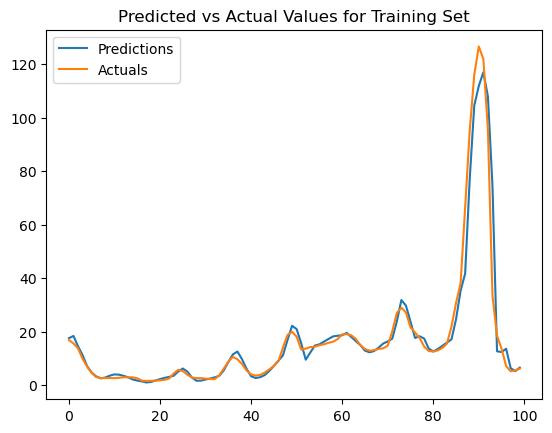

In [98]:
plt.plot(train_results2['Train Predictions'][:100])
plt.plot(train_results2['Actuals'][:100])
plt.title('Predicted vs Actual Values for Training Set')
plt.legend(['Predictions','Actuals']);

32. Calculate the predicted values for the validation set and add them to a dataframe along with the actuals.

In [99]:
val_predictions2 = model2.predict(X2_val).flatten()
val_results2 = pd.DataFrame(data={'Val Predictions': val_predictions2, 'Actuals': y2_val})
val_results2

94/94 [==============================] - 1s 6ms/step


,Val Predictions,Actuals
0,13.158305,5.95
1,4.460679,6.47
2,4.719938,8.21
3,7.801720,4.67
4,3.740158,4.16
...,...,...
2995,18.051649,17.85
2996,18.084139,18.36
2997,19.454304,18.85
2998,20.259136,16.84


33. Visualize the data to compare predicted values to the actual values for the validation set. For this set, it looks like the model did a little better at predicting that larger spike.

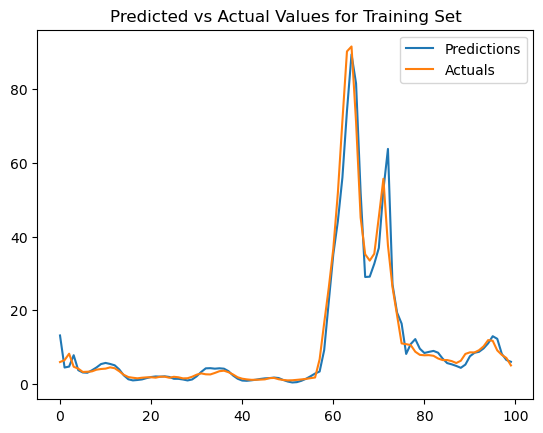

In [100]:
plt.plot(val_results2['Val Predictions'][:100])
plt.plot(val_results2['Actuals'][:100])
plt.title('Predicted vs Actual Values for Training Set')
plt.legend(['Predictions','Actuals']);

34. Calculate the predicted values for the training set and add them to a dataframe along with the actuals.

In [101]:
test_predictions2 = model2.predict(X2_test).flatten()
test_results2 = pd.DataFrame(data={'Test Predictions': test_predictions2, 'Actuals': y2_test})
test_results2

96/96 [==============================] - 1s 7ms/step


,Test Predictions,Actuals
0,18.444698,19.42
1,20.248428,22.37
2,23.055328,26.01
3,26.662588,23.03
4,20.726311,17.09
...,...,...
3048,30.673546,36.08
3049,44.360867,45.75
3050,50.461403,50.21
3051,48.213852,48.14


35. Visualize the data to compare predicted values to the actual values for the testing set. For this set, it looks like the model's predictions overshot the actuals for the larger spikes.

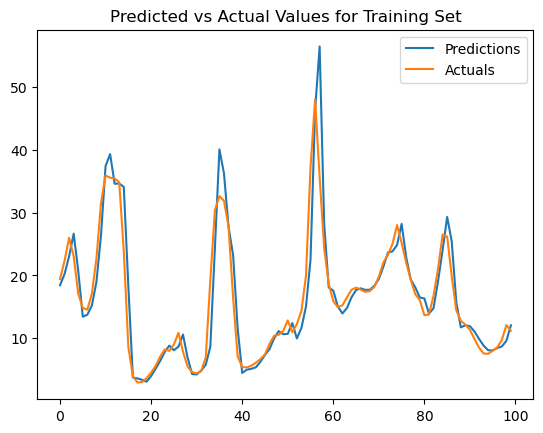

In [102]:
plt.plot(test_results2['Test Predictions'][:100])
plt.plot(test_results2['Actuals'][:100])
plt.title('Predicted vs Actual Values for Training Set')
plt.legend(['Predictions','Actuals']);

36. Calculate the coefficient of determination for the training set, validation set, and testing set. As you can see, the model performed well but it only performed better on the test set, the values for the other two sets are lower than our first LSTM model. Those values were .94 and .99 respectively, and now they are .92 and .90. The coefficient of determination for the last model's test set was .88 and this model's is .90, so while it is better, it only improved by .02. You could definitely refine the model to improve it, but overall it does not seem as if the added features are necessary like they were for XGBoost since our fist model performed quite well. 

In [103]:
train2_r2 = r2_score(train_results2['Actuals'],train_results2['Train Predictions'])
train2_r2

0.9281797642925328

In [104]:
val2_r2 = r2_score(val_results2['Actuals'],val_results2['Val Predictions'])
val2_r2

0.909138075244249

In [105]:
test2_r2 = r2_score(test_results2['Actuals'],test_results2['Test Predictions'])
test2_r2

0.9011490413852712